In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [64]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from kde_contour import kdeplot_2d_clevels
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import warnings

sns.set_context('notebook')
sns.set_palette('husl', n_colors=6)
sns.set_style('ticks')

Posterior sample file dowloaded from https://dcc.ligo.org/LIGO-P2000158/public.  There are multiple approximants in the file, but the "preferred" results come from a "NR surrogate" `NRSur7dq4`:

In [55]:
with h5py.File('GW190521_posterior_samples.h5', 'r') as f:
    print(list(f.keys()))
    samples = array(f['NRSur7dq4/posterior_samples'])

['IMRPhenomPv3HM', 'NRSur7dq4', 'SEOBNRv4PHM', 'history', 'version']


In [31]:
rng = np.random.default_rng(227735503557159763068367766824777508503)
c = rng.choice(len(samples), replace=False, size=16384)
sky_samples = pd.DataFrame({
    'x': samples['luminosity_distance'][c]*cos(samples['ra'][c])*cos(samples['dec'][c]),
    'y': samples['luminosity_distance'][c]*sin(samples['ra'][c])*cos(samples['dec'][c]),
    'z': samples['luminosity_distance'][c]*sin(samples['dec'][c])
})
sky_samples_plot = pd.DataFrame({
    r'$x$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*cos(samples['ra'][c])*cos(samples['dec'][c]),
    r'$y$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*sin(samples['ra'][c])*cos(samples['dec'][c]),
    r'$z$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*sin(samples['dec'][c])
})

[Graham, et al. (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.251102) reports the AGN at $\mathrm{RA} = 192.42625^\circ$, $\mathrm{DEC} = 34.82472^\circ$, and $z = 0.438$.  Converting to $xyz$ we have 

In [27]:
ra = 192.42625*pi/180.0
dec = 34.82472*pi/180
z = 0.438
d = Planck15.luminosity_distance(z).to(u.Mpc).value
xcounter = d*cos(ra)*cos(dec)
ycounter = d*sin(ra)*cos(dec)
zcounter = d*sin(dec)

pt_counter = array([xcounter, ycounter, zcounter])

This is a pretty typical skymap: there are two blobs on the sky.  It would be better to do some clustering or use the routines in https://lscsoft.docs.ligo.org/ligo.skymap/#plotting-and-visualization-ligo-skymap-plot, but we're being quick and dirty here.  The KDE that is estimated from the 3D positions will be over-dispersed because its bandwidth will be trying to account for the two blobs on either side of the origin; so take these results with a grain of salt.

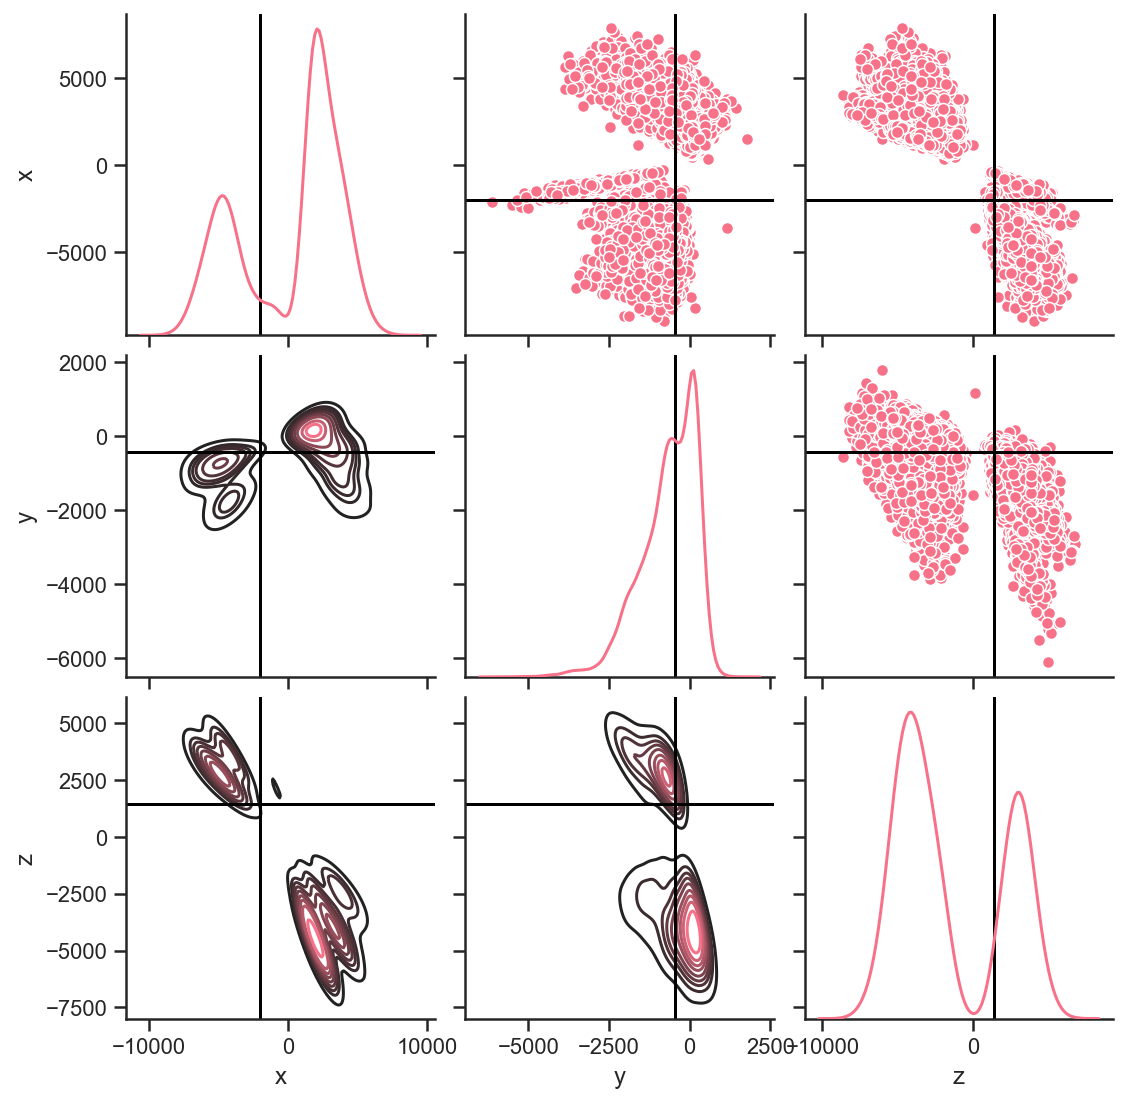

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Don't bitch about unused 'label' keyword.
    g = sns.PairGrid(sky_samples, diag_sharey=False)
    g.map_diag(sns.kdeplot)
    g.map_lower(kdeplot_2d_clevels)
    g.map_upper(sns.scatterplot)

    for i in range(3):
        for j in range(3):
            if i == j:
                g.axes[i,j].axvline(pt_counter[i], color='k')
            else:
                g.axes[i,j].axhline(pt_counter[i], color='k')
                g.axes[i,j].axvline(pt_counter[j], color='k')

To get a quick sense of the fraction of the volume posterior that would have to be searched before landing on the AGN, we rank the posterior samples according to an estimate of their 3D posterior density, and determine what fraction lie at lower rank than the AGN location.

In [34]:
pts = row_stack((sky_samples['x'], sky_samples['y'], sky_samples['z']))
kde = ss.gaussian_kde(pts)
p_pts = kde(pts)
p_counterpart = kde(pt_counter)

print('AGN lies at the {:.2f} percentile of the posterior'.format(count_nonzero(p_pts > p_counterpart) / float(len(p_pts))))

AGN lies at the 0.82 percentile of the posterior


We can also look at the marginal distance posterior along the LOS to the AGN.  Again, remember that the KDE is over-dispersed; a proper analysis would be more careful about clustering before computing KDEs.  Given that, however, we can just evaluate the full posterior along the line toward the AGN and re-normalize to obtain the conditional posterior for distance at the AGN location.

In [49]:
r_counter = sqrt(dot(pt_counter, pt_counter))
ds = linspace(0, 4*r_counter, 1024)
xhat = pt_counter / sqrt(dot(pt_counter, pt_counter))
pdist = kde(row_stack(ds[newaxis,:]*xhat[:,newaxis]))
pdist /= trapz(pdist, ds)

Text(0, 0.5, '$p\\left( d_L  \\mid \\mathrm{RA}, \\mathrm{DEC} \\right)$')

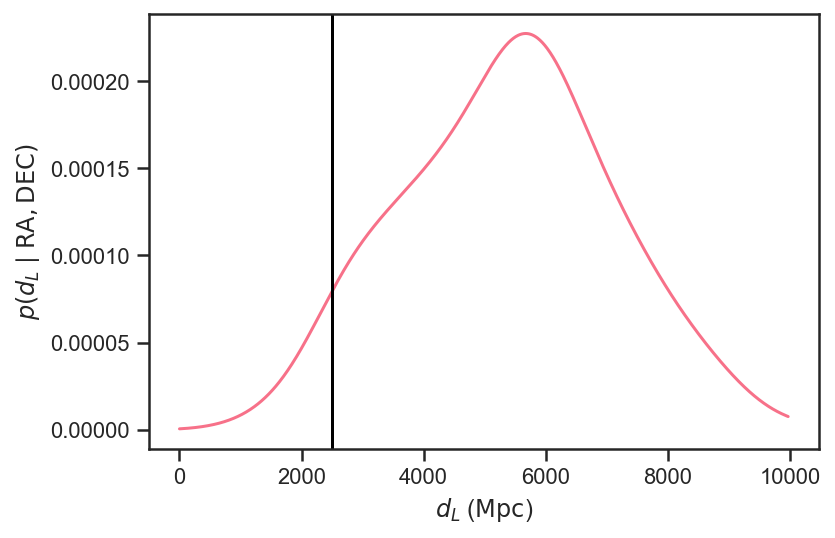

In [54]:
plot(ds, pdist)
axvline(r_counter, color='k')
xlabel(r'$d_L$ ($\mathrm{Mpc}$)')
ylabel(r'$p\left( d_L  \mid \mathrm{RA}, \mathrm{DEC} \right)$')

Sometimes these things work better in the principal axes of the skymap.  Here's what that looks like.  We rotate the point cloud so that the covariance matrix is diagonal.

In [68]:
pts = column_stack((sky_samples['x'], sky_samples['y'], sky_samples['z']))
S = cov(pts, rowvar=False)
evals, evecs = np.linalg.eigh(S)
rot_pts = np.dot(evecs.T, pts.T).T
rot_counter = np.dot(evecs.T, pt_counter)

In [66]:
rot_sky = pd.DataFrame({
    r'$\tilde{x}$ ($\mathrm{Mpc}$)': rot_pts[:,0],
    r'$\tilde{y}$ ($\mathrm{Mpc}$)': rot_pts[:,1],
    r'$\tilde{z}$ ($\mathrm{Mpc}$)': rot_pts[:,2]
})

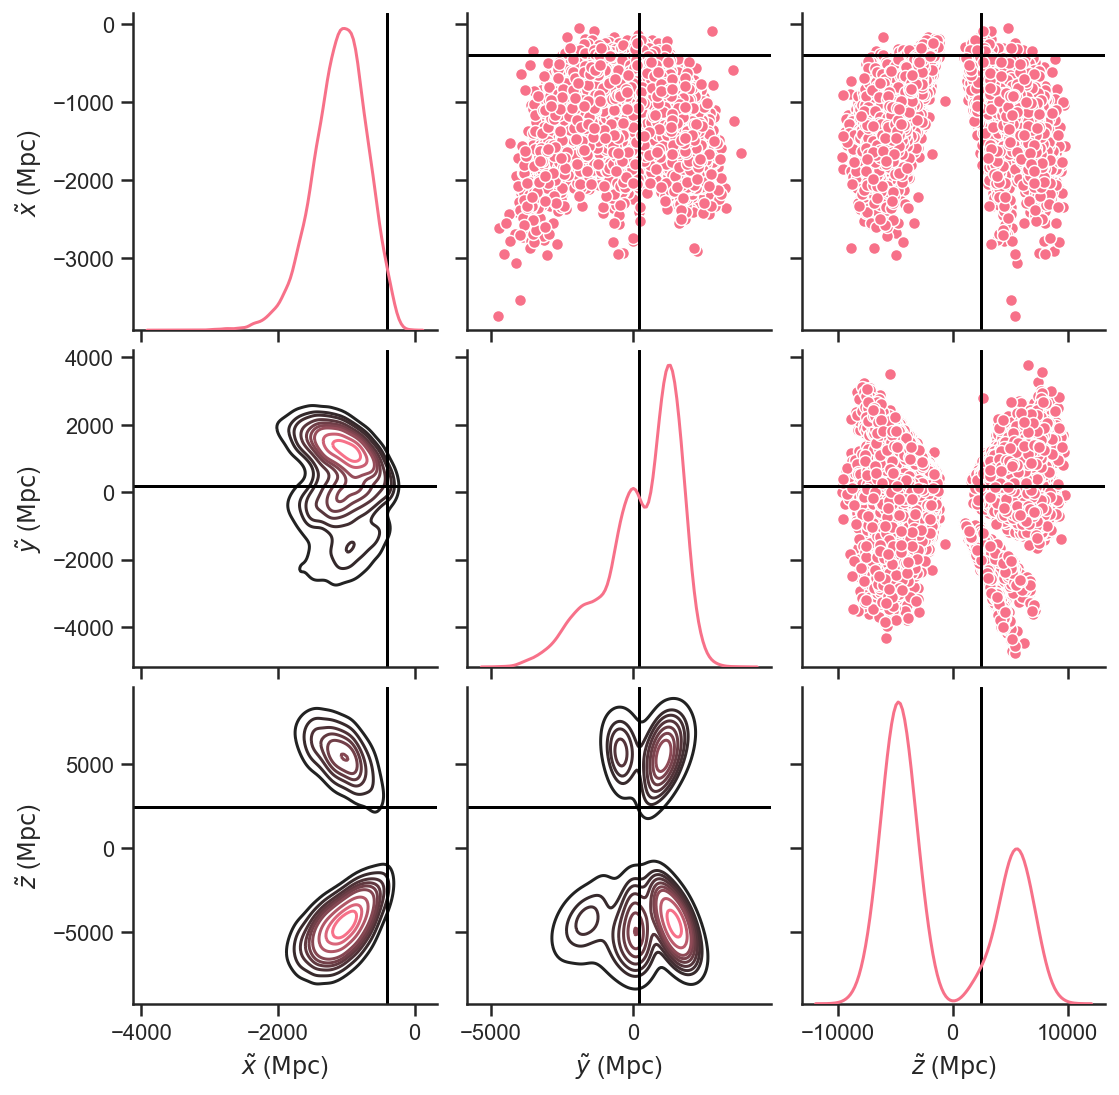

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Don't bitch about unused 'label' keyword.
    g = sns.PairGrid(rot_sky, diag_sharey=False)
    g.map_diag(sns.kdeplot)
    g.map_lower(kdeplot_2d_clevels)
    g.map_upper(sns.scatterplot)

    for i in range(3):
        for j in range(3):
            if i == j:
                g.axes[i,j].axvline(rot_counter[i], color='k')
            else:
                g.axes[i,j].axhline(rot_counter[i], color='k')
                g.axes[i,j].axvline(rot_counter[j], color='k')

This part comes out the same because the Gaussian KDE *does the rotation* before operating on the points:

In [70]:
kde = ss.gaussian_kde(rot_pts.T)
p_pts = kde(rot_pts.T)
p_counter = kde(rot_counter)

In [71]:
print('Counterpart found at the {:.2f} credible level of the posterior'.format(count_nonzero(p_pts > p_counter) / float(len(p_pts))))

Counterpart found at the 0.82 credible level of the posterior
